<a href="https://colab.research.google.com/github/kyle-gao/PointCloudTest/blob/main/O3dPointCloudOpinionDatasetAJavareriplyfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/AlirezaJav/IRPC-Dataset

Cloning into 'IRPC-Dataset'...
remote: Enumerating objects: 1560, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1560 (delta 3), reused 0 (delta 0), pack-reused 1551
Receiving objects: 100% (1560/1560), 3.33 GiB | 35.10 MiB/s, done.
Resolving deltas: 100% (497/497), done.
Checking out files: 100% (115/115), done.


In [3]:
!pip install open3d

     |████████████████████████████████| 188.4MB 57kB/s 


In [29]:
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from zipfile import ZipFile
import time
import open3d as o3d
import plotly.graph_objects as go

In [5]:
MOS = pd.read_excel("/content/IRPC-Dataset/MOS Scores.xlsx")
MOS_CommonSubjects = pd.read_excel("/content/IRPC-Dataset/MOS_CommonSubjects.xlsx")

In [6]:
MOS_CommonSubjects.head()

Unnamed: 0 Unnamed: 1  ... Unnamed: 5 Unnamed: 6
0         NaN        NaN  ...        NaN        NaN
1         NaN        NaN  ...        NaN        NaN
2         NaN        NaN  ...     Rcolor      Rmesh
3         NaN     Facade  ...    2.44444    3.66667
4         NaN        NaN  ...    3.33333    3.77778

[5 rows x 7 columns]

In [7]:
"""file_paths = os.listdir("/content/IRPC-Dataset/Original Point Clouds/12-bit")
target_folder = "/content/Original_PC/"
target_paths = []
for i in range(len(file_paths)):
  target_paths.append(target_folder+file_paths[i])
  file_paths[i] = "/content/IRPC-Dataset/Original Point Clouds/12-bit" + file_paths[i]"""

'file_paths = os.listdir("/content/IRPC-Dataset/Original Point Clouds/12-bit")\ntarget_folder = "/content/Original_PC/"\ntarget_paths = []\nfor i in range(len(file_paths)):\n  target_paths.append(target_folder+file_paths[i])\n  file_paths[i] = "/content/IRPC-Dataset/Original Point Clouds/12-bit" + file_paths[i]'

In [8]:
target_folder = "/content/Original_PC/"
if not(os.path.isdir(target_folder)):
  os.mkdir(target_folder)

In [9]:
!7z e "/content/IRPC-Dataset/Original Point Clouds/12-bit/Facade_O12.zip.001" -o"/content/Original_PC"
!7z e "/content/IRPC-Dataset/Decoded Point Clouds/PCL/Facade_PCL_L.zip" -o"/content/Distorted_PC"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/IRPC-Dataset/Original Point Clouds/12-bit/                                                             1 file, 26214400 bytes (25 MiB)

Extracting archive: /content/IRPC-Dataset/Original Point Clouds/12-bit/Facade_O12.zip.001
  0% 1 Open           --
Path = /content/IRPC-Dataset/Original Point Clouds/12-bit/Facade_O12.zip.001
Type = Split
Physical Size = 26214400
Volumes = 2
Total Physical Size = 29303767
----
Path = Facade_O12.zip
Size = 29303767
--
Path = Facade_O12.zip
Type = zip
Physical Size = 29303767

  0%     19% - Facade_O12.ply                     

In [10]:
ref_pc = o3d.io.read_point_cloud('/content/Original_PC/Facade_O12.ply')

In [11]:
dis_pc = o3d.io.read_point_cloud('/content/Distorted_PC/Facade_PCL_L.ply', format='ply')

In [16]:
dis_tree = o3d.geometry.KDTreeFlann(dis_pc)

In [22]:
#.search_knn_vector_3d(point,k)
# returns 
# k, indices, distances
[k, idx, z] = dis_tree.search_knn_vector_3d(dis_pc.points[1500], 200)


In [25]:
np.asarray(dis_pc.colors)[idx[1:], :] = [0, 1, 0]


In [33]:
points = np.asarray(dis_pc.points)
colors = np.asarray(dis_pc.colors)

In [34]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

PSNR implementation from MPEG

Mekuria et al. "INTERNATIONAL ORGANISATION FOR STANDARDISATION
ORGANISATION INTERNATIONALE DE NORMALISATION
ISO/IEC JTC1/SC29/WG11
CODING OF MOVING PICTURES AND AUDIO
" 2016.

In [115]:
dis_tree.search_knn_vector_3d(ref_pc.points[1],1)

(1, IntVector[9336], DoubleVector[94])

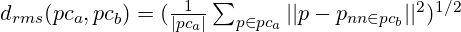


In [122]:
length = 1596085 
indices = np.zeros(length)
distances = np.zeros(length)
for i in range(length):
  ref_point = ref_pc.points[i]
  [_,idx,z] = dis_tree.search_knn_vector_3d(ref_point,1)
  indices[i]=idx.pop()
  distances[i]=z.pop()

In [150]:
def d_rms2 (pc_a,pc_b):
  total = 0
  l_a = np.asarray(pc_a.points).shape[0]
  b_tree = o3d.geometry.KDTreeFlann(pc_b)
  for i in range(l_a):
    ref_point = pc_a.points[i]
    [_,idx,_] = b_tree.search_knn_vector_3d(ref_point,1)
    idx = idx.pop()
    diff = ref_point-pc_b.points[idx]
    z = np.sum(diff**2)
    total += z
  drms = np.sqrt(total/l_a)
  return drms

In [159]:
def d_rms (pc_a,pc_b):
  total = 0
  l_a = np.asarray(pc_a.points).shape[0]
  b_tree = o3d.geometry.KDTreeFlann(pc_b)
  for i in range(l_a):
    ref_point = pc_a.points[i]
    [_,_,z] = b_tree.search_knn_vector_3d(ref_point,1)
    total += z.pop()
  drms = np.sqrt(total/l_a)
  return drms

In [176]:
def d_rms_hausd (pc_a,pc_b):
  total = 0
  maximum = 0
  l_a = np.asarray(pc_a.points).shape[0]
  b_tree = o3d.geometry.KDTreeFlann(pc_b)
  for i in range(l_a):
    ref_point = pc_a.points[i]
    [_,_,z] = b_tree.search_knn_vector_3d(ref_point,1)
    z = z.pop()
    total += z
    maximum = np.maximum(maximum,z)
  drms = np.sqrt(total/l_a)
  dhaus = np.sqrt(maximum)
  return drms,dhaus

In [177]:
def d_symmetric(pc_a,pc_b):
  d_rmsa,d_hausa = d_rms_hausd(pc_a,pc_b)
  d_rmsb,d_hausb = d_rms_hausd(pc_b,pc_a)
  return np.maximum(d_rmsa,d_rmsb), np.maximum(d_hausa,d_hausb)

In [178]:
d_sym_rms,d_sym_haus = d_symmetric(ref_pc,dis_pc)

In [160]:
rms_dist2 = d_rms2(ref_pc,dis_pc)
rms_dist2

8.025279824957531

In [180]:
d_sym_rms

8.025279824957531